# FDTD

### Libraries

In [9]:
import numpy as np
import math
from matplotlib import pyplot as plt 
import pandas as pd

### Variables and constants

In [15]:
lambda_min = 0.06  #minimum lambda in the wavelength regime.
lambda_max = 12.5  #maximum lambda in wavelength regime.
min_lam_sf = 10     #safety factor for the min labmda.
min_dim_x = 1.6779*10**-2       #minimum dimension
min_dim_y = 1.6779*10**-2       #minimum dimension
res_sf = 10          #resolution safety factor
c0 = 299792458  #speed of light.
critic_dim_x = 1.6779*10**-2 #a critical dimension that needs to be represented well
critic_dim_y = 1.6779*10**-2 #a critical dimension that needs to be represented well


layer1_x_dim = critic_dim_x
layer1_y_dim = critic_dim_y
eps_layer1 = 3.46
n_layer1 = np.sqrt(eps_layer1)


layer2_x_dim = 0.3048
layer2_y_dim = 0.3048

eps_layer2 = 12
n_layer2 = np.sqrt(eps_layer2)

layer3_x_dim = critic_dim_x
layer3_y_dim = critic_dim_y

eps_layer3 = 3.46
n_layer3 = np.sqrt(eps_layer3)

n_bc = 1  #refractive index of boundaries
n_max = max(n_layer1, n_layer2, n_layer3)

### Grid Resolution

delta_z is the pixel length. 
delta_z_init is the minimum of two options:
a- lambda_min/safety factor
b- minimum dimension/safety factor
we initialize it and then snap the grid to the critical dimension

In [33]:
delta_x_init = min(lambda_min / min_lam_sf, min_dim_x / res_sf)
delta_y_init = min(lambda_min / min_lam_sf, min_dim_y / res_sf)

print(delta_x_init)
Nx = math.ceil(critic_dim_x/ delta_x_init)
Ny = math.ceil(critic_dim_y/ delta_y_init)
print(Nx, Ny)

dx = critic_dim_x / Nx
dy = critic_dim_y / Ny
print(dx)

N_layer1_x = layer1_x_dim/dx
N_layer1_y = layer1_y_dim/dy

N_layer2_x = layer2_x_dim/dx
N_layer2_y = layer2_y_dim/dy


N_layer3_x = layer3_x_dim/dx
N_layer3_y = layer3_y_dim/dy


N_device_x = N_layer1_x + N_layer2_x + N_layer3_x
N_device_y = N_layer1_y + N_layer2_y + N_layer3_y

print(N_device_x, N_device_y)
Nx = N_device_x + (2*lambda_max) #spacer regions for visualising and/or for BC in 2D.
Ny = N_device_y + (2*lambda_max) #spacer regions for visualising and/or for BC in 2D.

print(Nx, Ny)
Nx= math.ceil(Nx)
Ny= math.ceil(Ny)

print(Nx, Ny)

#In case of only one layer:

Nx = int(N_layer1_x + (2*lambda_max))
Ny = int(N_layer1_y + (2*lambda_max))
print(Nx, Ny)

0.0016779
10 10
0.0016779
201.65564097979617 201.65564097979617
226.65564097979617 226.65564097979617
227 227
35 35


### Building device

In [34]:
# build a device
#ER_yy = np.ones((Nx, Ny)) # air
ER_zz = np.ones((Nx, Ny)) # air
UR_xx = np.ones((Nx, Ny)) # air and ALMOST all other materials.
UR_yy = np.ones((Nx, Ny)) # air and ALMOST all other materials.

In [35]:
# as a start, comment all of this out, so that we start with free space. 

# def build_layer_middle(N):  
#     device_start_pos = int(N/2) - round(N_device/2)
#     device_end_post = int(N/2) + math.ceil(N_device/2)
#     ER_yy[device_start_pos : device_end_post] = n_device**2
#     return ER_yy

# lay1_x_start = int(lambda_max)
# lay1_y_start = int(lambda_max)

# lay1_x_end = int(lay1_x_start + N_layer1_x)
# lay1_y_end = int(lay1_y_start + N_layer1_y)


# lay2_x_start = lay1_x_end
# lay2_y_start = lay1_y_end


# lay2_x_end = int(lay2_x_start + N_layer2_x)
# lay2_y_end = int(lay2_y_start + N_layer2_y)

# lay3_x_start = lay2_x_end
# lay3_y_start = lay2_y_end

# lay3_x_end = int(lay3_x_start + N_layer3_x)
# lay3_y_end = int(lay3_x_start + N_layer3_y)

# ER_yy[lay1_x_start : lay1_x_end] = eps_layer1 #wrong, should be loop for x and y.
# # ER_yy[lay2_start : lay2_end] = eps_layer2
# # ER_yy[lay3_start : lay3_end] = eps_layer3


### Visualising device

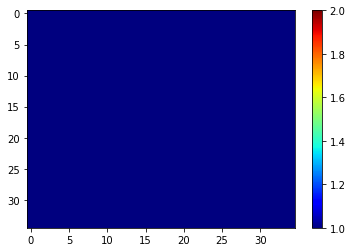

In [36]:
plt.imshow(ER_zz, cmap='jet',
           vmin=1, vmax=2, aspect='auto')
plt.colorbar()
plt.show()

# 'jet' is the colormap that is seen in the question's image, see also these colormaps

# setting origin='lowest' has the same effect than replacing np.transpose(Z)
# by np.transpose(Z)[::-1,]

# vmin, vmax give the scale (here from 0 to -100 dB in the example)

# extent gives the limits of the x-axis (here 0 to 4.2 seconds) and y-axis (0 to 48000 Hz) (in this example I'm plotting the spectrogram of a 4.2 second-long audio file of samplerate 96Khz)

# if aspect='auto' is not set, the plot would be very thin and very high (due to 4.2 vs. 48000 !)

### Time step

  time step, physical wave would not propagate further than a single unit cell in one time step.

In [37]:
dt= n_bc * min(dx, dy) / (2 * c0)  # Courant condition.

### Source

Since fmax = 1/pi.taw --> taw =~ 0.5/fmax.
The pulse source must start at zero and gradually increase. NO STEP FUNCTIONS

In [38]:
f_max = c0 / lambda_min

taw = 0.5 / f_max

t0 = 6 * taw
def g(t):
    """
    g(t): Gaussian source function
    """
    return   np.exp(-((t -  t0) / taw)**2)   
print("f max is ", f_max * 10**-12, "THz")

f max is  0.004996540966666667 THz


### TFSF

TFSF separates the total field and the scattered field into two separate regions. This is particularly useful for creating a one-way source, and for calculating the transmission and reflection spectra. 

In the separation, the equations should be adjusted because of the finite differencing, we have some points at the total field that take the field value of the scattered field and vice versa. 

In [39]:
# f_max = c0 / lambda_min
# taw = 0.5 / f_max
# t0 = 6 * taw
# def Ey_src(t):
#     """
#     g(t): Gaussian source function
#     """
#     return   np.exp(-((t -  t0)/taw)**2)   



# A = -1
# dt_src = (dt/2) + dz/(2*c0)
# def Hx_src(t):
#     """
#     g(t): Gaussian source function
#     """
    
#     return   A*np.exp(-((t-t0+dt_src) / taw)**2)   
    

# # Ey_src = np.vectorize(Ey_src)
# # Hx_src = np.vectorize(Hx_src) 

### Computations

Update coefficients are constants that will be used in the code below continiously, to save computation time, we calculate them once.

### Curls

In [40]:
CEx = np.zeros((Nx, Ny))
CEy = np.zeros((Nx, Ny))
CHz = np.zeros((Nx, Ny))

Ez = np.zeros((Nx, Ny))
Hx = np.zeros((Nx, Ny))
Hy = np.zeros((Nx, Ny))

Dz = np.zeros((Nx, Ny))


### Magnetic Field Normalization

The divergence equations were satisfied by adopting the Yee grid scheme. Now, only the the
curl equations have to be dealt with.
The 𝐸 and 𝐻 fields are related through the impedance of the material they are in, so they are
roughly three orders of magnitude different.

This may cause rounding errors in simulation and it is always good practice to normalize
parameters so they are all the same order of magnitude. Here, the magnetic field is
normalized

Normalization: H_tilde = eta_0 * H, eta_0 = 300

### Calculating number of time steps

How long does it take a wave to propagate across the grid (worst case)?

Simulation time T must include the entire pulse of duration.
Simulation time should allow for 5 bounces.

A rule-of-thumb for total simulation time is then 5 t_prop + 12 * taw.

In [41]:
t_prop = n_max * max(Nx,Ny) * max(dx, dy) / c0
T = 12*taw + 5* t_prop
STEPS = math.ceil(T/dt)
STEPS = 400

In [42]:
Ez_t = np.zeros((STEPS, Nx, Ny))
Ez_t.shape, Ez_t[0].shape

((400, 35, 35), (35, 35))

In [43]:
# MAIN FDTD LOOP 
#Storing a 3D array for the fields as a function of time i.e. Ez(t, x, y)
Ez_t=[]
Ez_tt=np.zeros([STEPS, Nx, Ny])
nxsrc = int(Nx/2)
nysrc = int(Ny/2)
for T in range(STEPS):  
    #Compute CEx:
    for nx in range(0, Nx): 
        for ny in range(0, Ny-1):
            CEx[nx,ny] = (Ez[nx,ny+1] - Ez[nx,ny])/dy
        CEx[nx,Ny-1] = (0 - Ez[nx, Ny-1])/dy
        
    #Compute CEy
    for ny in range(0, Ny): 
        for nx in range(0, Nx-1):
            CEy[nx,ny] = - (Ez[nx+1,ny] - Ez[nx,ny])/dx
        CEy[Nx-1,ny] = - (0 - Ez[Nx-1,ny])/dx
        
    #Update Equations:
    for ny in range(0, Ny): 
        for nx in range(0, Nx):
            Hx[nx, ny] = Hx[nx, ny] + ((-c0*dt/UR_xx[nx, ny])*CEx[nx,ny])
            Hy[nx, ny] = Hy[nx, ny] + ((-c0*dt/UR_yy[nx, ny])*CEy[nx,ny])        
        
    # Compute CHz
    CHz[0, 0] = (Hy[0, 0])/dx - (Hx[0, 0])/dy
    for nx in range (1, Nx):
        CHz[nx, 0] = (Hy[nx, 0] - Hy[nx-1, 0])/dx - (Hx[nx, 0])/dy

    for ny in range(1, Ny): 
        CHz[0,ny] = (Hy[0,ny])/dx - (Hx[0,ny] - Hx[0,ny-1])/dy
        for nx in range (1, Nx):
            CHz[nx,ny] = (Hy[nx,ny] - Hy[nx-1,ny])/dx - (Hx[nx,ny] - Hx[nx,ny-1])/dy  
    #Compute Dz:
    for ny in range(0, Ny):
        for nx in range(0, Nx):
            Dz[nx, ny] = Dz[nx, ny] + (c0*dt*CHz[nx,ny])
    Dz[nxsrc, nysrc] =  Dz[nxsrc, nysrc] + g(T*dt)
    #Compute Ez:
    for ny in range(0, Ny): 
        for nx in range(0, Nx):
            Ez[nx, ny] = (1/ER_zz[nx, ny])*(Dz[nx,ny])
            Ez_tt[T, nx, ny] = Ez[nx, ny]
            
    Ez_t.append(Ez)

In [97]:
from numpy import savetxt
np.save('Ez_tt.npy', Ez_tt)


In [74]:
Ez_t = np.array(Ez_t)
Ez_t.shape

(400, 35, 35)

In [75]:
Ez_t[120] == Ez_t[1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [108]:
# %matplotlib notebook
# from matplotlib.animation import FuncAnimation
# from matplotlib import pyplot as plt
# def animate(i):
#     ER_zz_i = ER_zz[i]
#     plt.cla() #clears axis so that we dont have overlaps
#     plt.clf() #clears figure.
#     plt.imshow(ER_zz_i, cmap='jet',
#            vmin=0, vmax=1, aspect='auto')
#     plt.colorbar()
# #     if i ==0:           #so that we dont have multiple colorbars.
# #         plt.colorbar()

        
    
    
# ani = FuncAnimation(plt.gcf(), animate, interval= 1000)


# plt.tight_layout()
# plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


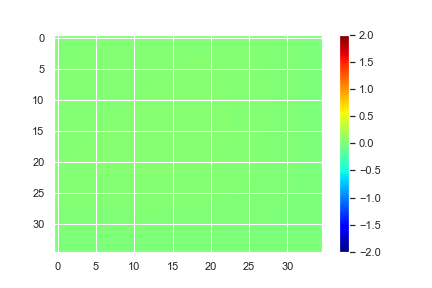

In [113]:
#here
plt.clf()
%matplotlib notebook

from matplotlib.animation import FuncAnimation
from matplotlib import pyplot as plt
def animate(i):
    Ez_tt_i = Ez_tt[i]
    plt.cla() #clears axis so that we dont have overlaps
    plt.clf() #clears figure.
    plt.imshow(Ez_tt_i, cmap='jet',vmin = -2, vmax=2,
           aspect='auto')
    plt.colorbar()
    #plt.title("field at time step " +str(i), "out of ", STEPS, fontsize = 18)
  # vmin=np.min(Ez_tt), vmax=np.max(Ez_tt),  
ani = FuncAnimation(plt.gcf(), animate, save_count = STEPS-1, interval= 50)

plt.tight_layout()
plt.show()
ani.save("2D_Field.mp4")



In [106]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation
from matplotlib import pyplot as plt
def animate(i):
    Ez_tt_i = Ez_tt[i]
    plt.cla() #clears axis so that we dont have overlaps
    plt.clf() #clears figure.
    
    plt.imshow(Ez_tt_i, cmap='jet', aspect='auto')
    plt.colorbar()   
  # vmin=np.min(Ez_tt), vmax=np.max(Ez_tt),  
ani = FuncAnimation(plt.gcf(), animate, interval= 50)
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

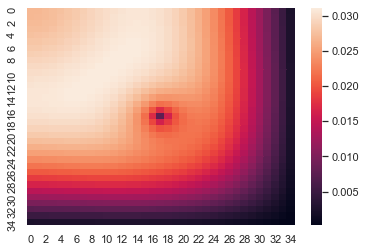

In [91]:
%matplotlib inline
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(Ez_tt[STEPS-180])

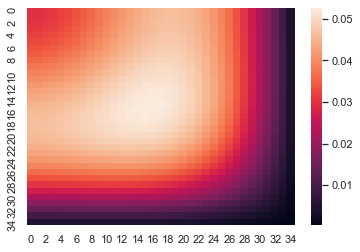

In [72]:
%matplotlib inline
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(Ez_tt[STEPS-1])

### Animating the field

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
Ez

array([[0.02977051, 0.02996809, 0.0303593 , ..., 0.01409956, 0.00949533,
        0.00477662],
       [0.02996809, 0.03016499, 0.03055482, ..., 0.0141117 , 0.00950331,
        0.00478057],
       [0.0303593 , 0.03055482, 0.03094192, ..., 0.01413529, 0.0095188 ,
        0.00478825],
       ...,
       [0.01409956, 0.0141117 , 0.01413529, ..., 0.00323687, 0.00217079,
        0.00108928],
       [0.00949533, 0.00950331, 0.0095188 , ..., 0.00217079, 0.00145578,
        0.00073048],
       [0.00477662, 0.00478057, 0.00478825, ..., 0.00108928, 0.00073048,
        0.00036654]])

In [50]:
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(Dz)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
plt.imshow(Dz)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
# # MAIN FDTD LOOP with perfect boundary conditions and FT.
# # H1 = 0
# # H2 = 0
# # E1 = 0
# # E2 = 0
# nzsrc = 4
# NFREQ = 1000
# FREQ = np.linspace(0, f_max, NFREQ)
# #Fourier Transforms:
# K = np.exp(-1j*2*np.pi*dt*FREQ).astype(complex)
# EyR = np.zeros(NFREQ).astype(complex)
# EyT = np.zeros(NFREQ).astype(complex)
# SRC = np.zeros(NFREQ).astype(complex)


    
# Ey_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# Hx_t = np.zeros([STEPS, N]) #time evolution of the field for all points.


# for T in range(STEPS):        
#     #Update H from E
#     #modificaion
#     H2=H1
#     H1=Hx[0]
#     for nz in range(N-1):
#         Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
#         Hx_t[T][nz] = Hx[nz] #recording field as a matrix
#     Hx[N-1] = Hx[N-1] + mHx[N-1]*(E2 - Ey[N-1])/dz #1D PML
#     # E2 = the field at the second last point of the grid two time steps earlier.
#     Hx[nzsrc-1] = Hx[nzsrc-1]\
#     -(Ey_src(T*dt) * mHx[nzsrc]/dz) #update equation with correction term of the TF/SF
# #     Hx[nzsrc-1] = Hx[nzsrc-1] + mHx[nzsrc-1]*\
# #     (Ey[nzsrc] - Ey[nzsrc-1])/dz-(Ey_src(T*dt) * mHx[nzsrc-1]/dz) #update equation with 
# #     # correction term of the TF/SF
   
    
            
#     Hx_t[T][N-1] = Hx[N-1] #recording field as a matrix
           
#     #Update E from H
#     #modification
#     E2=E1
#     E1=Ey[N-1]
#     Ey[0] = Ey[0] + mEy[0] * (Hx[0] - H2) / dz #1D PML.

#     Ey_t[T][0] = Ey[0]
    
#     for nz in range(1, N):
#         Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz
                    
#         Ey_t[T][nz] = Ey[nz] #recording field as a matrix
        
#     Ey[nzsrc] = Ey[nzsrc]\
#     - Hx_src(T*dt) * mEy[nzsrc-1]/dz 
# #Update Fourier Transforms
#     for nf in range(0, NFREQ):
#             EyR[nf] = EyR[nf] + (K[nf]**(T+1))*Ey[1]
#             EyT[nf] = EyT[nf] + (K[nf]**(T+1))*Ey[N-1]
#             SRC[nf] = SRC[nf] + (K[nf]**(T+1))*Ey_src((T+1)*dt)


In [53]:
# # MAIN FDTD LOOP with perfect boundary conditions
# H1 = 0
# H2 = 0
# E1 = 0
# E2 = 0
# nzsrc = 10
    
# Ey_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# Hx_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# for T in range(STEPS):        
#     #Update H from E
#     #modificaion
#     H2=H1
#     H1=Hx[0]
#     for nz in range(N-1):
#         Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
#         Hx_t[T][nz] = Hx[nz] #recording field as a matrix
#     Hx[N-1] = Hx[N-1] + mHx[N-1]*(E2 - Ey[N-1])/dz #1D PML
#     # E2 = the field at the second last point of the grid two time steps earlier.
#     Hx[nzsrc] = Hx[nzsrc] + mHx[nzsrc]*(Ey[nzsrc+1] - Ey[nzsrc])/dz\
#     -(Ey_src(T*dt) * mHx[nzsrc]/dz) #update equation with correction term of the TF/SF
# #     Hx[nzsrc-1] = Hx[nzsrc-1] + mHx[nzsrc-1]*\
# #     (Ey[nzsrc] - Ey[nzsrc-1])/dz-(Ey_src(T*dt) * mHx[nzsrc-1]/dz) #update equation with 
# #     # correction term of the TF/SF
    
    
            
#     Hx_t[T][N-1] = Hx[N-1] #recording field as a matrix
           
#     #Update E from H
#     #modification
#     E2=E1
#     E1=Ey[N-1]
#     Ey[0] = Ey[0] + mEy[0] * (Hx[0] - H2) / dz #1D PML.

#     Ey_t[T][0] = Ey[0]
    
#     for nz in range(1, N):
#         Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz
                    
#         Ey_t[T][nz] = Ey[nz] #recording field as a matrix
        
#     Ey[nzsrc] = Ey[nzsrc] + mEy[nzsrc]*(Hx[nzsrc] - Hx[nzsrc-1])/dz\
#     - Hx_src(T*dt) * mEy[nzsrc-1]/dz   


In [54]:
# Working code wo FT.
# # MAIN FDTD LOOP with perfect boundary conditions
# H1 = 0
# H2 = 0
# E1 = 0
# E2 = 0
# nzsrc = 2
    
# Ey_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# Hx_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# for T in range(STEPS):        
#     #Update H from E
#     #modificaion
#     H2=H1
#     H1=Hx[0]
#     for nz in range(N-1):
#         Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
#         Hx_t[T][nz] = Hx[nz] #recording field as a matrix
#     Hx[N-1] = Hx[N-1] + mHx[N-1]*(E2 - Ey[N-1])/dz #1D PML
#     # E2 = the field at the second last point of the grid two time steps earlier.
#     Hx[nzsrc-1] = Hx[nzsrc-1]\
#     -(Ey_src(T*dt) * mHx[nzsrc]/dz) #update equation with correction term of the TF/SF
# #     Hx[nzsrc-1] = Hx[nzsrc-1] + mHx[nzsrc-1]*\
# #     (Ey[nzsrc] - Ey[nzsrc-1])/dz-(Ey_src(T*dt) * mHx[nzsrc-1]/dz) #update equation with 
# #     # correction term of the TF/SF
    
    
            
#     Hx_t[T][N-1] = Hx[N-1] #recording field as a matrix
           
#     #Update E from H
#     #modification
#     E2=E1
#     E1=Ey[N-1]
#     Ey[0] = Ey[0] + mEy[0] * (Hx[0] - H2) / dz #1D PML.

#     Ey_t[T][0] = Ey[0]
    
#     for nz in range(1, N):
#         Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz
                    
#         Ey_t[T][nz] = Ey[nz] #recording field as a matrix
        
#     Ey[nzsrc] = Ey[nzsrc]\
#     - Hx_src(T*dt) * mEy[nzsrc-1]/dz   


In [55]:
# EyR_ = EyR*dt
# EyT_ = EyT*dt
# SRC_ = SRC*dt



# EyR_abs = np.abs(EyR_)
# EyT_abs = np.abs(EyT_)
# SRC_abs = np.abs(SRC_)

In [56]:
# plt.style.use('dark_background')

# plt.plot(FREQ, EyR_abs, label = 'EyR_')
# plt.plot(FREQ, EyT_abs, label = 'EyT_')

# plt.legend()
# plt.show()

In [57]:
# plt.style.use('dark_background')

# plt.plot(FREQ, EyR_abs, label = 'EyR_abs')
# plt.plot(FREQ, EyT_abs, label = 'EyT_abs')
# plt.plot(FREQ, SRC_abs, 'or', label = 'SRC_abs', linewidth = 0.2)


# plt.legend()
# plt.show()

In [58]:
# plt.style.use('dark_background')


# T = (EyT_abs/SRC_abs)**2
# R = (EyR_abs/SRC_abs)**2
# CON= T + R 


# plt.plot(FREQ, R, label = 'R')
# plt.plot(FREQ, T, label = 'T')
# plt.plot(FREQ, CON, '-.r', label = 'CON', linewidth = 4)


# plt.legend()
# plt.show()

In [59]:
# plt.style.use('dark_background')

# plt.plot(FREQ[0:500], EyR_abs[0:500], label = 'EyR_')
# plt.plot(FREQ[0:500], EyT_abs[0:500], label = 'EyT_')

# plt.legend()
# plt.show()

In [60]:
# g_vector = np.vectorize(g)
# source_t = g_vector(time_axis)
# source_f = np.abs(fft(source_t))
# plt.plot(time_axis, source_t, label = 'time')

# plt.legend()
# plt.show()

In [61]:
# # plt.plot(FREQ, source_f, label = 'frequency')
# # plt.show()
# NFREQ = STEPS
# FREQ = np.linspace(0, f_max, NFREQ)

In [62]:
# plt.style.use('dark_background')
# plt.plot(FREQ, EyR_abs, label = 'EyR_')
# plt.plot(FREQ, EyT_abs, label = 'EyT_')
# plt.plot(FREQ, source_f*10**-16, label = 'source')

# plt.legend()
# plt.show()


Below is a simple source.

In [63]:
# # MAIN FDTD LOOP with perfect boundary conditions
# H1 = 0
# H2 = 0
# E1 = 0
# E2 = 0


# Ey_t = np.zeros([STEPS, N]) #time evolution of the field for all points.
# Hx_t = np.zeros([STEPS, N]) #time evolution of the field for all points.

# for T in range(STEPS):        
#     #Update H from E
#     #modificaion
#     H2=H1
#     H1=Hx[0]
#     for nz in range(N-1):
#             Hx[nz] = Hx[nz] + mHx[nz]*(Ey[nz+1] - Ey[nz])/dz
#             Hx_t[T][nz] = Hx[nz] #recording field as a matrix
#     Hx[N-1] = Hx[N-1] + mHx[N-1]*(E2 - Ey[N-1])/dz #1D PML
#     # E2 = the field at the second last point of the grid two time steps earlier.

#     Hx_t[T][N-1] = Hx[N-1] #recording field as a matrix
           
#     #Update E from H
#     #modification
#     E2=E1
#     E1=Ey[N-1]
#     Ey[0] = Ey[0] + mEy[0] * (Hx[0] - H2) / dz #1D PML.

#     Ey_t[T][0] = Ey[0]
    
#     for nz in range(1, N):
#             Ey[nz] = Ey[nz] + mEy[nz]*(Hx[nz] - Hx[nz-1])/dz 
            
#             Ey_t[T][nz] = Ey[nz] #recording field as a matrix
            
#     Ey[2] = Ey[2] +g(T*dt)  # Simple source, gE is stored in an array of length STEPS    
#     #Ey[10] = g(T*dt)

In [64]:
#Denormalization of H field: would be hard to visualize.
# eta_0 = 300
# Hx_t =  Hx_t/eta_0
    

In [65]:
# freqs1 = np.linspace(0, f_max, STEPS)
# freqs = fftfreq(N_time_stamps, time_spacing)
# print(freqs)
# print(freqs1)


In [66]:
# #FFT of the last cell --> Transmission
# from scipy.fft import fft, fftfreq
# from sklearn import preprocessing

# #last_field_normalized = preprocessing.normalize(Ey_t[:, cell_number].reshape(-1,1))
# #first_field_normalized = preprocessing.normalize(Ey_t[:, 0].reshape(-1,1))
# last_field = Ey_t[:, cell_number].reshape(-1,1)
# first_field = Ey_t[:, 0].reshape(-1,1)
# time_stamps = np.linspace(0, STEPS*dt, STEPS)
# N_time_stamps = time_stamps.shape[0]
# time_spacing= dt
# freqs = fftfreq(N_time_stamps, time_spacing)
# #freqs = np.linspace(0, f_max, STEPS)
# plt.figure(figsize=(20,10))
# T = fft(last_field)
# R= fft(first_field)
# freq_pos = freqs[0:int(freqs.shape[0]/2)]
# T_pos = np.abs(T)[0:int(freqs.shape[0]/2)]
# R_pos = np.abs(R)[0:int(freqs.shape[0]/2)]
# CON_pos = T_pos + R_pos
# plt.plot(freq_pos, T_pos, label = "T", linewidth = 5)
# plt.plot(freq_pos,R_pos , label = "R", linewidth = 5)
# plt.plot(freq_pos, source_pos/max(source_pos), label = "source",  linewidth = 5)

# #plt.plot(freq_pos, CON, 'ro', label = "CON")
# #plt.plot(freqs, np.abs(T), label = "T")
# #plt.plot(freqs, np.abs(R), label = "R")
# #plt.scatter(freqs, np.abs(T)  + abs(R), label = "CON")
# plt.legend(fontsize = 25, loc='best')
# plt.xlabel("frequencies", fontsize = 25)
# plt.ylabel("Spectrum", fontsize = 25)
# plt.xticks(fontsize = 25)
# plt.yticks(fontsize = 25)
# plt.show()


In [67]:
#plots normalized:


# plt.plot(freq_pos, T_pos/(source_pos), label = "T")
# plt.plot(freq_pos,R_pos/(source_pos) , label = "R")
# plt.plot(freq_pos, CON/(source_pos), 'ro', label = "CON")
# plt.legend()

In [68]:
time_step = 0
%matplotlib inline
plt.plot(Ey_t[time_step, :]) 
plt.title("field at time step " +str(time_step))

# this is our frame Ey_t[time_step, :]


NameError: name 'Ey_t' is not defined

In [ ]:
Ey_t

In [ ]:
time_step = 40
%matplotlib inline
plt.plot(Ey_t[time_step, :]) 
plt.title("field at time step " +str(time_step))

# this is our frame Ey_t[time_step, :]


In [ ]:
plt.plot(Hx_t[:, 1])

### Creating animation for the fields evolutions

In [ ]:
%matplotlib nbagg

In [ ]:
%matplotlib inline

In [ ]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# define data
Edata = Ey_t
Hdata = Hx_t
# save to csv file
savetxt('Edata.csv', Edata, delimiter=',')
savetxt('Hdata.csv', Hdata, delimiter=',')

In [ ]:
Efield = pd.read_csv('Edata.csv')
Hfield = pd.read_csv('Hdata.csv')


In [ ]:
# for i in Efield.shape[0]:
#     if 

In [ ]:
# Efield

In [ ]:
# STEPS

In [ ]:
!cd